**AI & Machine Learning (KAN-CINTO4003U) - Copenhagen Business School | Spring 2025**

***


# Part I: Bag-of-Words Model

Please see the description of the assignment in the README file (section 1) <br>
**Guide notebook**: [guides/bow_guide.ipynb](guides/bow_guide.ipynb)


***

<br>

* Note that you should report results using a classification report. 

* Also, remember to include some reflections on your results: Are there any hyperparameters that are particularly important?

* You should follow the steps given in the `bow_guide` notebook

<br>

***

In [71]:
# imports for the project

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from collections import Counter


### 1. Load the data

We can load this data directly from [Hugging Face Datasets](https://huggingface.co/docs/datasets/) - The HuggingFace Hub- into a Pandas DataFrame. Pretty neat!

**Note**: This cell will download the dataset and keep it in memory. If you run this cell multiple times, it will download the dataset multiple times.

You are welcome to increase the `frac` parameter to load more data.

In [72]:

splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}

train = pd.read_parquet("hf://datasets/fancyzhx/ag_news/" + splits["train"])
test = pd.read_parquet("hf://datasets/fancyzhx/ag_news/" + splits["test"])

print(train.shape, test.shape)

(120000, 2) (7600, 2)


In [73]:

label_map = {
    0: 'World',
    1: 'Sports',
    2: 'Business',
    3: 'Sci/Tech'
}

def preprocess(df: pd.DataFrame, frac : float = 1e-2, label_map : dict[int, str] = label_map, seed : int = 42) -> pd.DataFrame:
    """ Preprocess the dataset 

    Operations:
    - Map the label to the corresponding category
    - Filter out the labels not in the label_map
    - Sample a fraction of the dataset (stratified by label)

    Args:
    - df (pd.DataFrame): The dataset to preprocess
    - frac (float): The fraction of the dataset to sample in each category
    - label_map (dict): A mapping of the original label to the new label
    - seed (int): The random seed for reproducibility

    Returns:
    - pd.DataFrame: The preprocessed dataset
    """

    return  (
        df
        .assign(label=lambda x: x['label'].map(label_map))
        [lambda df: df['label'].isin(label_map.values())]
        .groupby('label')[["text", "label"]]
        .apply(lambda x: x.sample(frac=frac, random_state=seed))
        .reset_index(drop=True)

    )

train_df = preprocess(train, frac=0.01)
test_df = preprocess(test, frac=0.1)

# clear up some memory by deleting the original dataframes
del train
del test

train_df.shape, test_df.shape

((1200, 2), (760, 2))

2. Split the data

In [74]:
(
    
    X_train,
    X_val,
    y_train,
    y_val

) = train_test_split(train_df["text"], train_df["label"], test_size=0.2, random_state=42)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(960,) (240,) (960,) (240,)


3. Build the BoW Model

In [75]:
# Remove stop words, numbers, single letters and create the document-term matrix
cv = CountVectorizer(
    stop_words='english', 
    min_df=5, 
    max_df=0.8, 
    ngram_range=(1, 2), 
    lowercase=True, 
    token_pattern=r'\b[a-zA-Z]{2,}\b',
    strip_accents='unicode', 
    analyzer='word',

)
X_train_vectorized = cv.fit_transform(X_train)

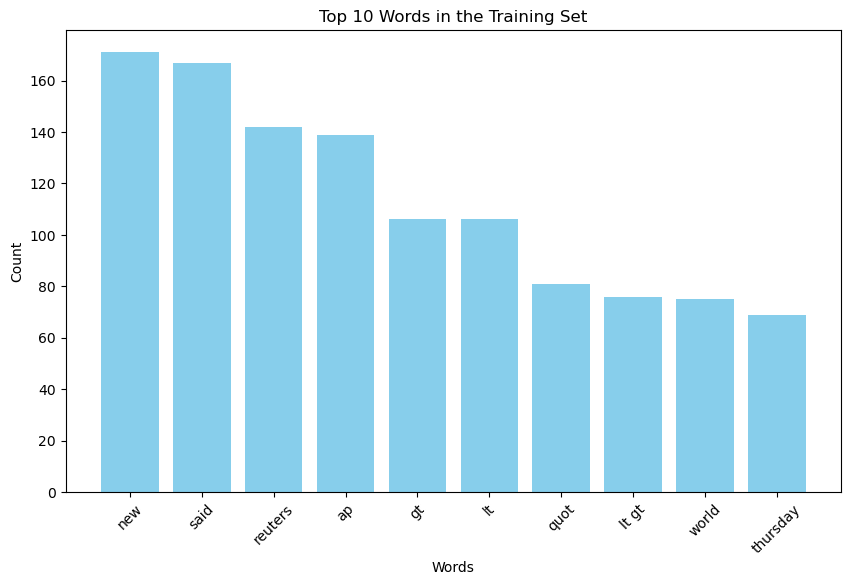

In [76]:
# Sum the occurrences of each word across all documents
word_counts = np.asarray(X_train_vectorized.sum(axis=0)).flatten()

# Create a DataFrame with words and their corresponding counts
word_freq = pd.DataFrame({'word': cv.get_feature_names_out(), 'count': word_counts})

# Define the visualization function
def visualize_top_n_tokens(word_freq, n=10):
    # Sort the DataFrame by count in descending order and select the top N words
    top_n_words = word_freq.sort_values(by='count', ascending=False).head(n)

    # Create the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(top_n_words['word'], top_n_words['count'], color='skyblue')
    plt.xlabel('Words')
    plt.ylabel('Count')
    plt.title(f'Top {n} Words in the Training Set')
    plt.xticks(rotation=45)
    plt.show()

# Visualize the top 10 words
visualize_top_n_tokens(word_freq, n=10)

In [77]:
X_train_vectorized.todense()
#cv.vocabulary_

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

Test: Print most common names

In [78]:
# Sum the occurrences of each word across all documents
word_counts = np.asarray(X_train_vectorized.sum(axis=0)).flatten()

# Create a DataFrame with words and their corresponding counts
word_freq = pd.DataFrame({'word': cv.get_feature_names_out(), 'count': word_counts})

# Sort the DataFrame by count in descending order and display the top 10 words
top_10_words = word_freq.sort_values(by='count', ascending=False).head(10)
print(top_10_words)

         word  count
604       new    171
775      said    167
755   reuters    142
48         ap    139
372        gt    106
520        lt    106
719      quot     81
521     lt gt     76
992     world     75
906  thursday     69


Test the word counting

In [79]:
word = "new"
if word in cv.get_feature_names_out():
    print(f"The word {word} is in the vocabulary.")
else:
    print(f"The word {word} is not in the vocabulary.")

the_index = cv.get_feature_names_out().tolist().index(word)
the_count = word_counts[the_index]
print(f"The word {word} occurred {the_count} times in the training set.")
# Ensure that the word "the" is in the vocabulary
if word in cv.get_feature_names_out():
    print(f"The word {word} is in the vocabulary.")
else:
    print(f"The word {word} is not in the vocabulary.")

# Get the index of the word "the" in the vocabulary
the_index = cv.get_feature_names_out().tolist().index(word)

# Use this index to find the count of the word "the" in the word_counts array
the_count = word_counts[the_index]
print(f"The word {word} occurred {the_count} times in the training set.")

The word new is in the vocabulary.
The word new occurred 171 times in the training set.
The word new is in the vocabulary.
The word new occurred 171 times in the training set.


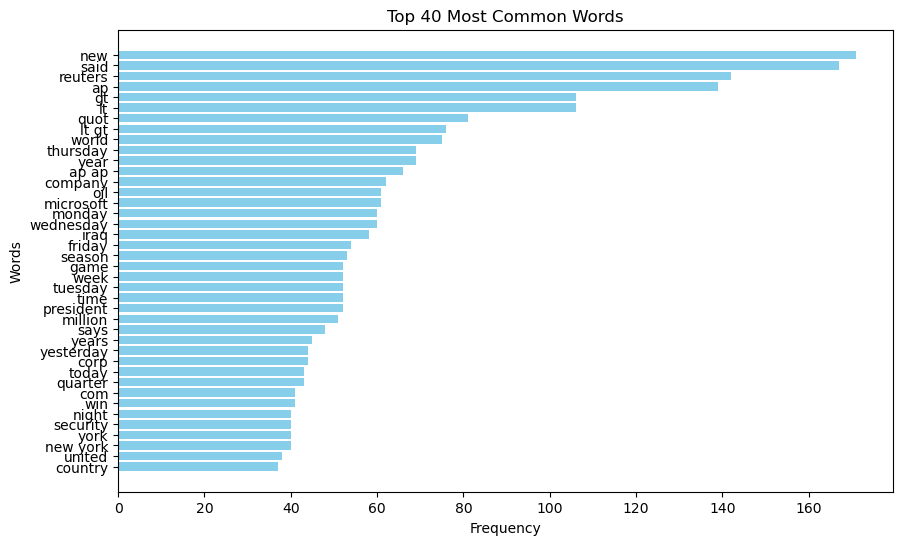

In [80]:
# Visualize the top N tokens
def visualize_top_n_tokens(word_freq, n=40):
    # Sort the DataFrame by count in descending order and select the top N words
    top_n_words = word_freq.sort_values(by='count', ascending=False).head(n)

    # Create the bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_n_words['word'], top_n_words['count'], color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title(f'Top {n} Most Common Words')
    plt.gca().invert_yaxis()  # Invert y-axis to show the highest frequency at the top
    plt.show()

# Call the function with the word_freq DataFrame
visualize_top_n_tokens(word_freq, n=40)

4. Create classifier

In [81]:
# adding hyperparameters to the logistic regression model
# Initialize the logistic regression classifier
lr_clf = LogisticRegression(max_iter=1000, C=1.0, solver='liblinear', random_state=42, class_weight='balanced')

lr_clf.fit(X_train_vectorized, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='liblinear')

5. Get predictions and evaluate the model

In [82]:
X_val_vectorized = cv.transform(X_val) # note that we use transform here, not fit_transform

y_pred = lr_clf.predict(X_val_vectorized)

In [83]:
print("Performance on the training set:")
print(classification_report(y_train, lr_clf.predict(X_train_vectorized), target_names=label_map.values()))

print("Performance on the validation set:")
print(classification_report(y_val, y_pred, target_names=label_map.values()))

Performance on the training set:
              precision    recall  f1-score   support

       World       1.00      0.99      0.99       238
      Sports       0.98      1.00      0.99       240
    Business       1.00      1.00      1.00       240
    Sci/Tech       1.00      0.99      1.00       242

    accuracy                           0.99       960
   macro avg       0.99      0.99      0.99       960
weighted avg       0.99      0.99      0.99       960

Performance on the validation set:
              precision    recall  f1-score   support

       World       0.77      0.58      0.66        62
      Sports       0.76      0.63      0.69        60
    Business       0.76      0.85      0.80        60
    Sci/Tech       0.67      0.88      0.76        58

    accuracy                           0.73       240
   macro avg       0.74      0.74      0.73       240
weighted avg       0.74      0.73      0.73       240



In [95]:
test_df_vectorized = cv.transform(test_df["text"])

print("Performance on the test set:")
print(classification_report(test_df["label"], lr_clf.predict(test_df_vectorized), target_names=label_map.values()))

Performance on the test set:
              precision    recall  f1-score   support

       World       0.75      0.73      0.74       190
      Sports       0.78      0.72      0.75       190
    Business       0.84      0.85      0.85       190
    Sci/Tech       0.77      0.84      0.81       190

    accuracy                           0.79       760
   macro avg       0.79      0.79      0.78       760
weighted avg       0.79      0.79      0.78       760



Performance on the training set:
              precision    recall  f1-score   support

       World       0.92      0.84      0.88       238
      Sports       0.87      0.91      0.89       240
    Business       0.94      0.98      0.96       240
    Sci/Tech       0.93      0.92      0.92       242

    accuracy                           0.91       960
   macro avg       0.91      0.91      0.91       960
weighted avg       0.91      0.91      0.91       960

Performance on the validation set:
              precision    recall  f1-score   support

       World       0.80      0.66      0.73        62
      Sports       0.83      0.67      0.74        60
    Business       0.81      0.92      0.86        60
    Sci/Tech       0.71      0.90      0.79        58

    accuracy                           0.78       240
   macro avg       0.79      0.79      0.78       240
weighted avg       0.79      0.78      0.78       240



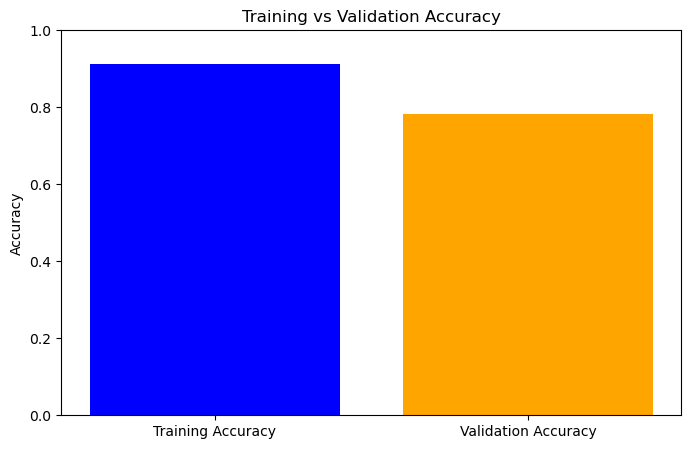

In [92]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
nb_clf = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

# Train the Naive Bayes classifier
nb_clf = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
nb_clf.fit(X_train_vectorized, y_train)

# Transform validation data
X_val_vectorized = cv.transform(X_val)

# Predict on training and validation sets
y_train_pred = nb_clf.predict(X_train_vectorized)
y_val_pred = nb_clf.predict(X_val_vectorized)

# Calculate accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Print classification reports
print("Performance on the training set:")
print(classification_report(y_train, y_train_pred, target_names=label_map.values()))

print("Performance on the validation set:")
print(classification_report(y_val, y_val_pred, target_names=label_map.values()))

# Visualize the accuracy
plt.figure(figsize=(8, 5))
plt.bar(['Training Accuracy', 'Validation Accuracy'], [train_accuracy, val_accuracy], color=['blue', 'orange'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.show()

In [94]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

# Initialize the Logistic Regression classifier
lr_clf = LogisticRegression(max_iter=1000, C=1.0, solver='liblinear', random_state=42, class_weight='balanced')
lr_clf.fit(X_train_vectorized, y_train)

# Initialize the Multinomial Naive Bayes classifier
nb_clf = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
nb_clf.fit(X_train_vectorized, y_train)

# Transform validation data
X_val_vectorized = cv.transform(X_val)

# Predict on training and validation sets for Logistic Regression
y_train_pred_lr = lr_clf.predict(X_train_vectorized)
y_val_pred_lr = lr_clf.predict(X_val_vectorized)

# Predict on training and validation sets for MultinomialNB
y_train_pred_nb = nb_clf.predict(X_train_vectorized)
y_val_pred_nb = nb_clf.predict(X_val_vectorized)

# Calculate accuracy scores
train_accuracy_lr = accuracy_score(y_train, y_train_pred_lr)
val_accuracy_lr = accuracy_score(y_val, y_val_pred_lr)

train_accuracy_nb = accuracy_score(y_train, y_train_pred_nb)
val_accuracy_nb = accuracy_score(y_val, y_val_pred_nb)

# Print classification reports
#print("Logistic Regression - Training Performance:")
#print(classification_report(y_train, y_train_pred_lr, target_names=label_map.values()))
print("Logistic Regression - Validation Performance:")
print(classification_report(y_val, y_val_pred_lr, target_names=label_map.values()))

#print("MultinomialNB - Training Performance:")
#print(classification_report(y_train, y_train_pred_nb, target_names=label_map.values()))
print("MultinomialNB - Validation Performance:")
print(classification_report(y_val, y_val_pred_nb, target_names=label_map.values()))

# Create a DataFrame to compare accuracy scores
comparison_df = pd.DataFrame({
    "Model": ["Logistic Regression", "MultinomialNB"],
    "Training Accuracy": [train_accuracy_lr, train_accuracy_nb],
    "Validation Accuracy": [val_accuracy_lr, val_accuracy_nb]
})

# Display the comparison
print("\nAccuracy Comparison:")
print(comparison_df)

Logistic Regression - Validation Performance:
              precision    recall  f1-score   support

       World       0.77      0.58      0.66        62
      Sports       0.76      0.63      0.69        60
    Business       0.76      0.85      0.80        60
    Sci/Tech       0.67      0.88      0.76        58

    accuracy                           0.73       240
   macro avg       0.74      0.74      0.73       240
weighted avg       0.74      0.73      0.73       240

MultinomialNB - Validation Performance:
              precision    recall  f1-score   support

       World       0.80      0.66      0.73        62
      Sports       0.83      0.67      0.74        60
    Business       0.81      0.92      0.86        60
    Sci/Tech       0.71      0.90      0.79        58

    accuracy                           0.78       240
   macro avg       0.79      0.79      0.78       240
weighted avg       0.79      0.78      0.78       240


Accuracy Comparison:
                 Model

In [96]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

# Initialize the Logistic Regression classifier
lr_clf = LogisticRegression(max_iter=1000, C=1.0, solver='liblinear', random_state=42, class_weight='balanced')
lr_clf.fit(X_train_vectorized, y_train)

# Initialize the Multinomial Naive Bayes classifier
nb_clf = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
nb_clf.fit(X_train_vectorized, y_train)

# Transform validation and test data
X_val_vectorized = cv.transform(X_val)
X_test_vectorized = cv.transform(test_df["text"])

# Predict on training, validation, and test sets for Logistic Regression
y_train_pred_lr = lr_clf.predict(X_train_vectorized)
y_val_pred_lr = lr_clf.predict(X_val_vectorized)
y_test_pred_lr = lr_clf.predict(X_test_vectorized)

# Predict on training, validation, and test sets for MultinomialNB
y_train_pred_nb = nb_clf.predict(X_train_vectorized)
y_val_pred_nb = nb_clf.predict(X_val_vectorized)
y_test_pred_nb = nb_clf.predict(X_test_vectorized)

# Calculate accuracy scores
train_accuracy_lr = accuracy_score(y_train, y_train_pred_lr)
val_accuracy_lr = accuracy_score(y_val, y_val_pred_lr)
test_accuracy_lr = accuracy_score(test_df["label"], y_test_pred_lr)

train_accuracy_nb = accuracy_score(y_train, y_train_pred_nb)
val_accuracy_nb = accuracy_score(y_val, y_val_pred_nb)
test_accuracy_nb = accuracy_score(test_df["label"], y_test_pred_nb)

# Print classification reports for the test set
print("Logistic Regression - Test Performance:")
print(classification_report(test_df["label"], y_test_pred_lr, target_names=label_map.values()))

print("MultinomialNB - Test Performance:")
print(classification_report(test_df["label"], y_test_pred_nb, target_names=label_map.values()))

# Create a DataFrame to compare accuracy scores
comparison_df = pd.DataFrame({
    "Model": ["Logistic Regression", "MultinomialNB"],
    "Training Accuracy": [train_accuracy_lr, train_accuracy_nb],
    "Validation Accuracy": [val_accuracy_lr, val_accuracy_nb],
    "Test Accuracy": [test_accuracy_lr, test_accuracy_nb]
})

# Display the comparison
print("\nAccuracy Comparison:")
print(comparison_df)

Logistic Regression - Test Performance:
              precision    recall  f1-score   support

       World       0.75      0.73      0.74       190
      Sports       0.78      0.72      0.75       190
    Business       0.84      0.85      0.85       190
    Sci/Tech       0.77      0.84      0.81       190

    accuracy                           0.79       760
   macro avg       0.79      0.79      0.78       760
weighted avg       0.79      0.79      0.78       760

MultinomialNB - Test Performance:
              precision    recall  f1-score   support

       World       0.79      0.73      0.76       190
      Sports       0.76      0.76      0.76       190
    Business       0.86      0.85      0.85       190
    Sci/Tech       0.80      0.87      0.83       190

    accuracy                           0.80       760
   macro avg       0.80      0.80      0.80       760
weighted avg       0.80      0.80      0.80       760


Accuracy Comparison:
                 Model  Training A